# Outlier detection

In this notebook, I present how Similarity Forest can be used for outlier detection.
KDDCup99 http network attacks dataset is used to compare its performance with Isolation Forest.

Both algorithms work similarly. Unsupervised, random splits are made to partition the data. Average depth, at which a data-point is isolated is used to score its `outlyingness`. The assumption here, is that outliers are often isolated with small number of splits - they lay in regions with lower density, so it's easier to isolate them.

The difference between the algorithms is, that Similarity Forest does not use features directly. What it does instead, is a projection of data-points on a line, drawn through two randomly chosen data-points. The procedure involves comparing the data-points using a specified similarity function. The default choice is to use dot product.

In [1]:
from simforest.outliers import IsolationSimilarityForest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.datasets import fetch_kddcup99
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from yellowbrick.model_selection import ValidationCurve

sns.set_style('whitegrid')
plt.set_cmap('Blues')

SEED=42

import warnings
warnings.filterwarnings('ignore')

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<Figure size 576x396 with 0 Axes>

# The dataset

The dataset was used in KDD Cup 1999, that involved building a predictive model capable of distinguishing between ``bad`` connections, called intrusions or attacks, and ``good`` normal connections [1]. There is much more normal connections, that bad ones - they are outliers. For the purpose of this experiment, all classes of attacks are aggregated into one outlier class.

The dataset is splitted into training and test set. The features are scaled.

[1] The description comes from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html website.

In [2]:
# Fetch data
X, y = fetch_kddcup99(subset='http', random_state=SEED, return_X_y=True)
X, y = X.astype(np.float32), y.astype('str')

# Fix classes
y_df = pd.DataFrame(y, columns=['class'])
y_df.loc[y_df['class'] != 'normal.', 'class'] = -1
y_df.loc[y_df['class'] == 'normal.', 'class'] = 1
y = y_df.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.ravel().astype(np.int32)
y_test = y_test.ravel().astype(np.int32)

We can see that there is very little outliers in the data. The model is not aware of the labels, but we can take a look at them.

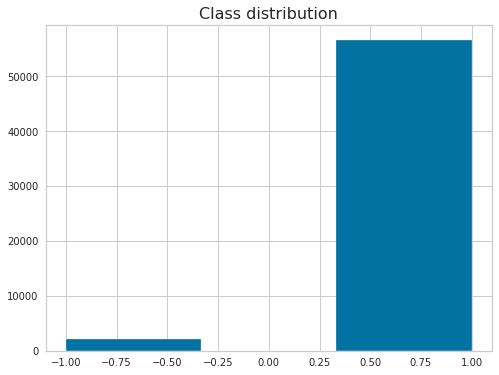

In [3]:
plt.figure(figsize=(8, 6))
plt.hist(y, bins=3)
plt.title('Class distribution', fontsize=16);

# Performance comparison

Isolation Similarity Forest class follows the API of Scikit-Learn. The model is build using model.fit(X) function. Note that in case of outlier detection we don't provide label information to the model.

After fitting the models, we use hold-out dataset, to compare scores that the models produce with the labels. Area under ROC curve is used to compare the performance.

Similarity Forest ROC-AUC score: 0.962
Similarity Forest precision: 1.0
Similarity Forest recall: 0.96
Similarity Forest f1: 0.979


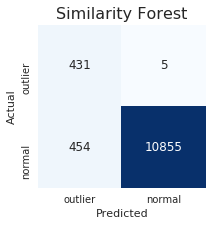

In [4]:
# Fit the model and score data points
SF = IsolationSimilarityForest(n_estimators=100, random_state=SEED)
SF.fit(X_train)
sf_pred = SF.decision_function(X_test)
print(f'Similarity Forest ROC-AUC score: {round(roc_auc_score(y_test, sf_pred), 3)}')

# Get class predictions
sf_class_preds = np.ones_like(sf_pred)
sf_class_preds[sf_pred <= 0] = -1
print(f'Similarity Forest precision: {round(precision_score(y_test, sf_class_preds), 3)}')
print(f'Similarity Forest recall: {round(recall_score(y_test, sf_class_preds), 3)}')
print(f'Similarity Forest f1: {round(f1_score(y_test, sf_class_preds), 3)}')

# Plot confusion matrix
plt.figure(figsize=(3, 3))
cm = confusion_matrix(y_test, sf_class_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g',  cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Similarity Forest', fontsize=16);

Isolation Forest ROC-AUC score: 0.993
Isolation Forest precision: 1.0
Isolation Forest recall: 0.908
Isolation Forest f1: 0.952


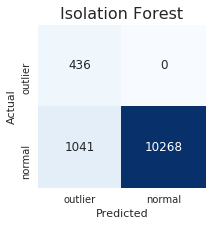

In [5]:
# Fit the model and score data points
IF = IsolationForest(random_state=SEED)
IF.fit(X_train)
if_pred = IF.decision_function(X_test)
print(f'Isolation Forest ROC-AUC score: {round(roc_auc_score(y_test, if_pred), 3)}')

# Get class predictions
if_class_preds = np.ones_like(if_pred)
if_class_preds[if_pred <= 0] = -1
print(f'Isolation Forest precision: {round(precision_score(y_test, if_class_preds), 3)}')
print(f'Isolation Forest recall: {round(recall_score(y_test, if_class_preds), 3)}')
print(f'Isolation Forest f1: {round(f1_score(y_test, if_class_preds), 3)}')

# Plot confusion matrix
plt.figure(figsize=(3, 3))
cm = confusion_matrix(y_test, if_class_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Isolation Forest', fontsize=16);

# Contamination parameter

We can also specify `contamination` fraction in the dataset, that is the fraction of expected outliers. If such assumption is possible, we can use it.

Similarity Forest ROC-AUC score: 0.962
Similarity Forest precision: 1.0
Similarity Forest recall: 0.935
Similarity Forest f1: 0.967


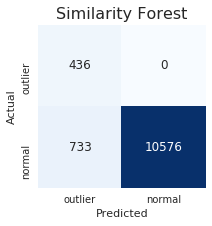

In [6]:
# Fit the model and score data points
SF = IsolationSimilarityForest(n_estimators=100, random_state=SEED, contamination=0.1)
SF.fit(X_train)
sf_pred = SF.decision_function(X_test)
print(f'Similarity Forest ROC-AUC score: {round(roc_auc_score(y_test, sf_pred), 3)}')

# Get class predictions
sf_class_preds = np.ones_like(sf_pred)
sf_class_preds[sf_pred <= 0] = -1
print(f'Similarity Forest precision: {round(precision_score(y_test, sf_class_preds), 3)}')
print(f'Similarity Forest recall: {round(recall_score(y_test, sf_class_preds), 3)}')
print(f'Similarity Forest f1: {round(f1_score(y_test, sf_class_preds), 3)}')

# Plot confusion matrix
plt.figure(figsize=(3, 3))
cm = confusion_matrix(y_test, sf_class_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g',  cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Similarity Forest', fontsize=16);

# Number of trees

The plot shows how Similarity Forest performance depends on number of trees.

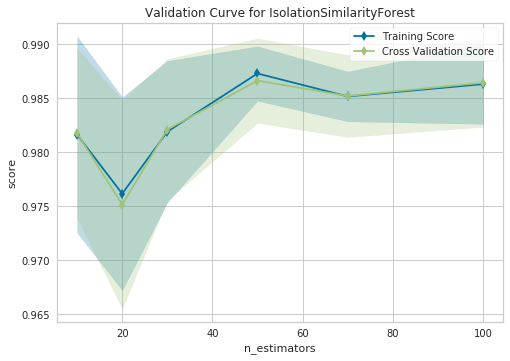

In [7]:
sf_visualizer = ValidationCurve(
    IsolationSimilarityForest(), param_name='n_estimators',
    param_range=[10, 20, 30, 50, 70, 100], cv=5, scoring='roc_auc'
)

sf_visualizer.fit(X_train, y_train)
sf_visualizer.show();